In [10]:
%matplotlib inline
 
import gzip
import pickle
from urllib.request import urlretrieve
import zipfile
 
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

with gzip.open("mnist.pkl.gz") as f:
    train_data, _, test_data = pickle.load(f, encoding="latin1")
train_data = list(train_data)
test_data = list(test_data)

ImportError: No module named 'nengo_ocl'

In [2]:
data = train_data

In [3]:
one_hot = np.zeros((data[0].shape[0], 10))

In [4]:
one_hot[np.arange(data[0].shape[0]), data[1]] = 1

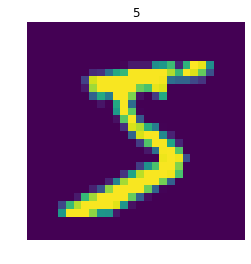

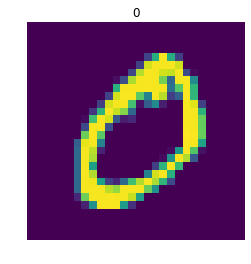

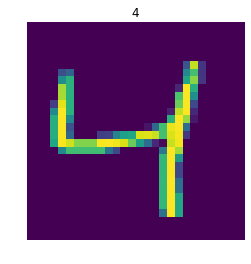

In [5]:
for data in (train_data, test_data):
    one_hot = np.zeros((data[0].shape[0], 10))
    one_hot[np.arange(data[0].shape[0]), data[1]] = 1
    data[1] = one_hot
 
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_data[0][i], (28, 28)))
    plt.axis('off')
    plt.title(str(np.argmax(train_data[1][i])));

In [6]:
with nengo.Network() as net:

    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    neuron_type = nengo.LIF(amplitude=0.01)
 
    nengo_dl.configure_settings(trainable=False)
 
    inp = nengo.Node([0] * 28 * 28)
 
    x = nengo_dl.tensor_layer(inp, tf.layers.conv2d, shape_in=(28, 28, 1), filters=32, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)
 
    x = nengo_dl.tensor_layer(x, tf.layers.conv2d, shape_in=(26, 26, 32), filters=64, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)
 
    x = nengo_dl.tensor_layer(x, tf.layers.average_pooling2d, shape_in=(24, 24, 64), pool_size=2, strides=2)
 
    x = nengo_dl.tensor_layer(x, tf.layers.conv2d, shape_in=(12, 12, 64), filters=128, kernel_size=3)
    x = nengo_dl.tensor_layer(x, neuron_type)
 
    x = nengo_dl.tensor_layer(x, tf.layers.average_pooling2d, shape_in=(10, 10, 128), pool_size=2, strides=2)
    x = nengo_dl.tensor_layer(x, tf.layers.dense, units=10)
 
    out_p = nengo.Probe(x)
    out_p_filt = nengo.Probe(x, synapse=0.1)

In [7]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:01                                               
Construction finished in 0:00:01                                               #########################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

In [8]:
train_inputs = {inp: train_data[0][:, None, :]}
train_targets = {out_p: train_data[1][:, None, :]}
 
n_steps = 30
test_inputs = {inp: np.tile(test_data[0][:minibatch_size*2, None, :], (1, n_steps, 1))}
test_targets = {out_p_filt: np.tile(test_data[1][:minibatch_size*2, None, :], (1, n_steps, 1))}

In [11]:
def objective(x, y):
    return tf.nn.softmax_cross_entropy_with_logits_v2(logits=x, labels=y)
 
 
opt = tf.train.RMSPropOptimizer(learning_rate=0.001)
 
def classification_error(outputs, targets):
    return 100 * tf.reduce_mean(
        tf.cast(tf.not_equal(tf.argmax(outputs[:, -1], axis=-1),
                             tf.argmax(targets[:, -1], axis=-1)),
                tf.float32))


print("error before training: %.2f%%" % sim.loss(
    test_data, {out_p_filt: classification_error}))

AttributeError: 'list' object has no attribute 'values'

In [12]:
sim.train(train_inputs, train_targets, opt, objective={out_p: objective}, n_epochs=10)
sim.save_params("./mnist_params")
 
 
print("error after training: %.2f%%" % sim.loss(test_inputs, test_targets, {out_p_filt: classification_error}))

TypeError: train() got multiple values for argument 'n_epochs'